# Lab 07-3 linear regression - Eager (normalization, decay, l2_loss)

* linear regression에 Normalization, Learning Decay, L2_loss를 적용

### 기본 Library 선언 및 Tensorflow 버전 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()
tf.set_random_seed(777)  # for reproducibility

print(tf.__version__)

1.12.0


### 정규화를 위한 함수 (최대 최소값이 1과 0이되도록 Scaling한다)

In [2]:
def normalization(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / denominator

### 강의에 설명할 Data입니다
* X Data(feature)의 값은 해당 배열의 첫번째 값부터 4번째 값까지로 정의 되고 Y Data(label)는 해당 배열의 마지막 값을 정의(5번째 값)

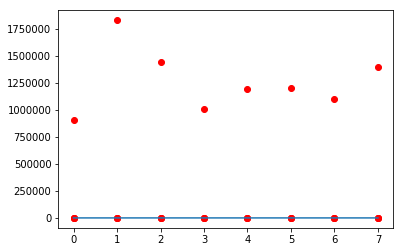

In [3]:
xy = np.array([[828.659973, 833.450012, 908100, 828.349976, 831.659973],
               [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
               [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
               [816, 820.958984, 1008100, 815.48999, 819.23999],
               [819.359985, 823, 1188100, 818.469971, 818.97998],
               [819, 823, 1198100, 816, 820.450012],
               [811.700012, 815.25, 1098100, 809.780029, 813.669983],
               [809.51001, 816.659973, 1398100, 804.539978, 809.559998]])

x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(x_train, 'ro')
plt.plot(y_train)
plt.show()


* Data에 표준화를 적용하여 실행한다

[[1.         1.         0.         1.         1.        ]
 [0.70548491 0.70439552 1.         0.71881783 0.83755792]
 [0.54412549 0.50274824 0.57608696 0.60646801 0.6606331 ]
 [0.33890353 0.31368023 0.10869565 0.45989134 0.43800918]
 [0.51436    0.4258239  0.30434783 0.58504805 0.42624401]
 [0.49556179 0.4258239  0.31521739 0.48131134 0.49276137]
 [0.11436064 0.         0.20652174 0.22007776 0.18597238]
 [0.         0.07747099 0.5326087  0.         0.        ]]


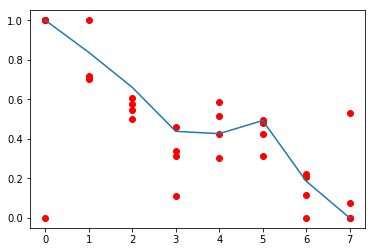

In [4]:
xy = normalization(xy)
print(xy)
x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(x_train, 'ro')
plt.plot(y_train)

plt.show()

##  Tensorflow Session
### 위 Data를 기준으로 Linear Regression 모델을 만들도록 하겠습니다
* Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
* X(features),Y(labels)는 실재 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

* W와 b은 학습을 통해 생성되는 모델에 쓰이는 Wegith와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal / tf.zeros)

In [6]:
W = tf.Variable(tf.random_normal([4, 1]), dtype=tf.float32)
b = tf.Variable(tf.random_normal([1]), dtype=tf.float32)

* Linear Regression의 Hyphthesis를 정의한다 (y=Wx+b)

In [7]:
def linearReg_fn(features):
    hypothesis = tf.matmul(features, W) + b
    return hypothesis

### L2 loss를 적용할 함수를 정의한다
* Weight의 수가 많아지면 수만큼 더한다 tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)

In [8]:
def l2_loss(loss, beta = 0.01):
    W_reg = tf.nn.l2_loss(W) # output = sum(t ** 2) / 2
    loss = tf.reduce_mean(loss + W_reg * beta)
    return loss

* 가설을 검증할 Cost 함수를 정의합니다(Mean Square Error를 사용)

In [9]:
def loss_fn(hypothesis, features, labels, flag = False):
    cost = tf.reduce_mean(tf.square(hypothesis - labels))
    if(flag):
        cost = l2_loss(cost)
    return cost

### Learning Rate 값을 조정하기 위한 Learning Decay 설정 
#### 5개 파라미터 설정
* starter_learning_rate : 최초 학습시 사용될 learning rate (0.1로 설정하여 0.96씩 감소하는지 확인)
* global_step : 현재 학습 횟수
* 1000 : 곱할 횟수 정의 (1000번에 마다 적용)
* 0.96 : 기존 learning에 곱할 값
* 적용유무 decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
* decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

In [10]:
is_decay = True
starter_learning_rate = 0.1

if(is_decay):
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 50, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
else:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=starter_learning_rate)

def grad(hypothesis, features, labels, l2_flag):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(linearReg_fn(features),features,labels, l2_flag)
    return tape.gradient(loss_value, [W,b]), loss_value

### Tensorflow를 통한 실행을 위해 Session을 실행합니다. (L2 loss)

In [11]:
EPOCHS = 101

for step in range(EPOCHS):
    for features, labels  in tfe.Iterator(dataset):
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        grads, loss_value = grad(linearReg_fn(features), features, labels, False)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]), global_step=global_step)
        if step % 10 == 0:
            print("Iter: {}, Loss: {:.4f}, Learning Rate: {:.8f}".format(step, loss_value, optimizer._learning_rate()))

Iter: 0, Loss: 1.7346, Learning Rate: 0.10000000
Iter: 10, Loss: 0.0745, Learning Rate: 0.10000000
Iter: 20, Loss: 0.0438, Learning Rate: 0.10000000
Iter: 30, Loss: 0.0273, Learning Rate: 0.10000000
Iter: 40, Loss: 0.0181, Learning Rate: 0.10000000
Iter: 50, Loss: 0.0128, Learning Rate: 0.09600000
Iter: 60, Loss: 0.0099, Learning Rate: 0.09600000
Iter: 70, Loss: 0.0080, Learning Rate: 0.09600000
Iter: 80, Loss: 0.0068, Learning Rate: 0.09600000
Iter: 90, Loss: 0.0060, Learning Rate: 0.09600000
Iter: 100, Loss: 0.0054, Learning Rate: 0.09216000
